# Amazon Climate Hot-Event Prediction with Neural Networks

**Goal:** Predict (1) extreme heat events (classification) and (2) monthly temperature (regression) using large-scale climate indices (ENSO, NAO, TSA, TNA) and seasonal encoding.

**Key ML practices:** leakage-safe preprocessing, train/val/test splits, year-wise generalisation testing, model serialisation, reproducibility (seeded).

## Project structure

This notebook provides a transparent, end-to-end walkthrough of the data preparation,
modeling, and evaluation steps.

Reusable training and evaluation logic is implemented as modular Python scripts
inside the `src/` directory.

- Train and serialize all models: `python -m src.train_all`
- Load saved models and run evaluations: `python -m src.evaluate_all`

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Paths (notebook is in /notebooks)
ROOT = Path("..")
DATA_DIR = ROOT / "data"
FIG_DIR = ROOT / "figures"
MODEL_DIR = ROOT / "models"

FIG_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

# Training defaults
EPOCHS_CLF = 60
EPOCHS_REG = 80
BATCH_SIZE = 32
LR = 1e-3

## 1. Data loading

In [5]:
df = pd.read_csv(DATA_DIR / "Amazon_temperature_student.csv")
thresholds = pd.read_csv(DATA_DIR / "thresholds.csv")

print("df columns:", list(df.columns))
print("thresholds columns:", list(thresholds.columns))
df.head()

df columns: ['year', 'month', 'temperature', 'TSA', 'ENSO', 'NAO', 'TNA']
thresholds columns: ['month', 'threshold']


,year,month,temperature,TSA,ENSO,NAO,TNA
0,1982,1,25.938068,0.03,0.13,-1.55,0.19
1,1982,10,27.525936,-0.11,1.99,-0.29,-0.34
2,1982,11,27.586092,-0.28,1.92,1.55,-0.46
3,1982,12,27.096022,-0.17,2.20,1.56,-0.50
4,1982,2,25.861292,-0.20,-0.17,0.86,-0.07


In [6]:
# Standardise common column names (adjust only if your CSV differs)
rename_map = {}
for c in df.columns:
    cl = c.strip().lower()
    if cl == "year":
        rename_map[c] = "Year"
    elif cl == "month":
        rename_map[c] = "Month"
    elif cl in {"temp", "temperature", "t"}:
        rename_map[c] = "Temp"
    elif cl == "enso":
        rename_map[c] = "ENSO"
    elif cl == "nao":
        rename_map[c] = "NAO"
    elif cl == "tsa":
        rename_map[c] = "TSA"
    elif cl == "tna":
        rename_map[c] = "TNA"

df = df.rename(columns=rename_map)

thr_rename = {}
for c in thresholds.columns:
    cl = c.strip().lower()
    if cl == "month":
        thr_rename[c] = "Month"
    elif cl in {"threshold", "temp_threshold", "temperature_threshold"}:
        thr_rename[c] = "Threshold"
thresholds = thresholds.rename(columns=thr_rename)

required = {"Year","Month","Temp","ENSO","NAO","TSA","TNA"}
assert required.issubset(df.columns), f"Missing columns: {required - set(df.columns)}"
assert {"Month","Threshold"}.issubset(thresholds.columns), f"Bad thresholds columns: {thresholds.columns}"

df = df.sort_values(["Year","Month"]).reset_index(drop=True)
thresholds = thresholds[["Month","Threshold"]].copy()

df.head()

,Year,Month,Temp,TSA,ENSO,NAO,TNA
0,1982,1,25.938068,0.03,0.13,-1.55,0.19
1,1982,2,25.861292,-0.20,-0.17,0.86,-0.07
2,1982,3,26.212032,-0.21,0.13,0.80,-0.07
3,1982,4,26.226341,-0.35,0.21,-0.04,-0.16
4,1982,5,26.316759,-0.37,0.45,-0.44,-0.03


## 2. Target construction (Hot events)

In [7]:
thr_map = thresholds.set_index("Month")["Threshold"]
df["Threshold"] = df["Month"].map(thr_map)

if df["Threshold"].isna().any():
    missing = sorted(df.loc[df["Threshold"].isna(), "Month"].unique())
    raise ValueError(f"Missing thresholds for months: {missing}")

df["Hot"] = (df["Temp"] > df["Threshold"]).astype(int)

df[["Year","Month","Temp","Threshold","Hot"]].head(12)

,Year,Month,Temp,Threshold,Hot
0,1982,1,25.938068,27.205489,0
1,1982,2,25.861292,26.782966,0
2,1982,3,26.212032,26.590744,0
3,1982,4,26.226341,26.645223,0
4,1982,5,26.316759,26.712053,0
5,1982,6,26.437941,26.719718,0
6,1982,7,26.228416,26.798165,0
7,1982,8,26.661893,26.963596,0
8,1982,9,27.252241,27.321035,0
9,1982,10,27.525936,27.732373,0


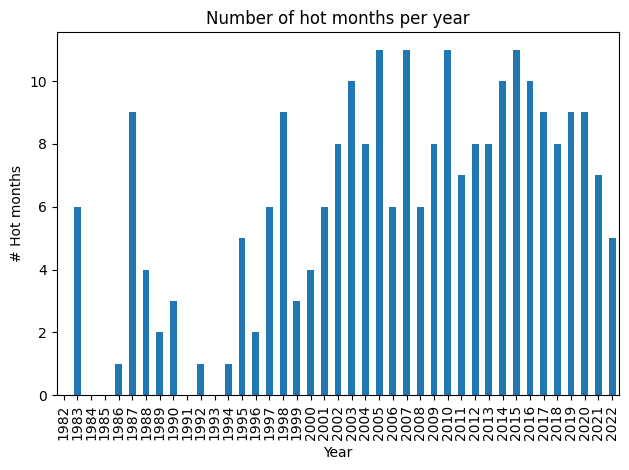

In [8]:
hot_by_year = df.groupby("Year")["Hot"].sum()

plt.figure()
hot_by_year.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("# Hot months")
plt.title("Number of hot months per year")
plt.tight_layout()
plt.savefig(FIG_DIR / "hot_months_per_year.png", dpi=200)
plt.show()

## 3. Feature engineering & preprocessing

In [9]:
theta = 2*np.pi*(df["Month"].astype(float) - 1.0)/12.0
df["Month_sin"] = np.sin(theta)
df["Month_cos"] = np.cos(theta)

FEATURES = ["ENSO","NAO","TSA","TNA","Month_sin","Month_cos"]
df[FEATURES + ["Temp","Hot"]].head()

,ENSO,NAO,TSA,TNA,Month_sin,Month_cos,Temp,Hot
0,0.13,-1.55,0.03,0.19,0.000000,1.000000e+00,25.938068,0
1,-0.17,0.86,-0.20,-0.07,0.500000,8.660254e-01,25.861292,0
2,0.13,0.80,-0.21,-0.07,0.866025,5.000000e-01,26.212032,0
3,0.21,-0.04,-0.35,-0.16,1.000000,6.123234e-17,26.226341,0
4,0.45,-0.44,-0.37,-0.03,0.866025,-5.000000e-01,26.316759,0


In [10]:
from sklearn.model_selection import train_test_split

train_df, tmp_df = train_test_split(df, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)
val_df, test_df = train_test_split(tmp_df, test_size=0.50, random_state=RANDOM_SEED, shuffle=True)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

(len(train_df), len(val_df), len(test_df))

(344, 74, 74)

In [11]:
def Xy_for_classification(d):
    X = d[FEATURES].to_numpy(dtype=float)
    y = d["Hot"].to_numpy(dtype=int)
    return X, y

def Xy_for_regression(d):
    X = d[FEATURES].to_numpy(dtype=float)
    y = d["Temp"].to_numpy(dtype=float)
    return X, y

## 4. Task A — Classification model

In [12]:
from sklearn.preprocessing import StandardScaler
import joblib

X_train, y_train = Xy_for_classification(train_df)
X_val, y_val = Xy_for_classification(val_df)
X_test, y_test = Xy_for_classification(test_df)

clf_scaler = StandardScaler().fit(X_train)
X_train_s = clf_scaler.transform(X_train)
X_val_s = clf_scaler.transform(X_val)
X_test_s = clf_scaler.transform(X_test)


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

clf = keras.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

clf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

hist_clf = clf.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=EPOCHS_CLF,
    batch_size=BATCH_SIZE,
    verbose=0
)

# Save artifacts
clf.save(MODEL_DIR / "classification_model.keras")
joblib.dump(clf_scaler, MODEL_DIR / "classification_scaler.joblib")

['..\\models\\classification_scaler.joblib']

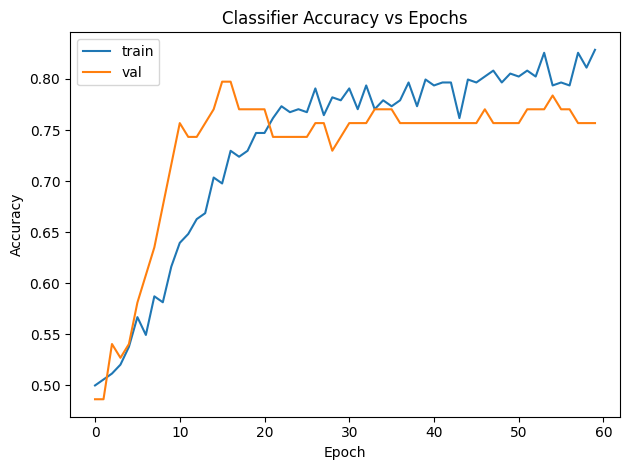

In [14]:
plt.figure()
plt.plot(hist_clf.history["accuracy"], label="train")
plt.plot(hist_clf.history["val_accuracy"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy vs Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "clf_accuracy_vs_epochs.png", dpi=200)
plt.show()

## 5. Task A — Evaluation

In [15]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

y_prob = clf.predict(X_test_s, verbose=0).reshape(-1)
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
bal_acc = balanced_accuracy_score(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()
tnr = tn/(tn+fp) if (tn+fp) else np.nan
tpr = tp/(tp+fn) if (tp+fn) else np.nan

print("Balanced Accuracy:", round(bal_acc, 4))
print("Specificity (TNR):", round(tnr, 4))
print("Sensitivity (TPR):", round(tpr, 4))
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)

Balanced Accuracy: 0.8121
Specificity (TNR): 0.7632
Sensitivity (TPR): 0.8611
Confusion matrix [[TN FP],[FN TP]]:
 [[29  9]
 [ 5 31]]


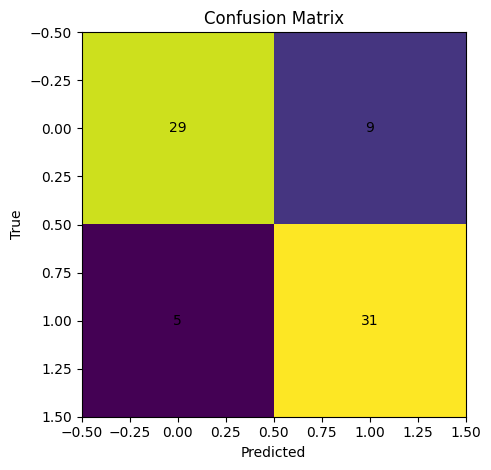

In [16]:
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.savefig(FIG_DIR / "clf_confusion_matrix.png", dpi=200)
plt.show()

## 6. Task B — Regression model (random split)

In [17]:
X_train_r, y_train_r = Xy_for_regression(train_df)
X_val_r, y_val_r = Xy_for_regression(val_df)
X_test_r, y_test_r = Xy_for_regression(test_df)

reg_scaler = StandardScaler().fit(X_train_r)
X_train_rs = reg_scaler.transform(X_train_r)
X_val_rs = reg_scaler.transform(X_val_r)
X_test_rs = reg_scaler.transform(X_test_r)

In [18]:
reg = keras.Sequential([
    layers.Input(shape=(X_train_rs.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

reg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="mae"
)

hist_reg = reg.fit(
    X_train_rs, y_train_r,
    validation_data=(X_val_rs, y_val_r),
    epochs=EPOCHS_REG,
    batch_size=BATCH_SIZE,
    verbose=0
)

# Save artifacts
reg.save(MODEL_DIR / "regression_model.keras")
joblib.dump(reg_scaler, MODEL_DIR / "regression_feature_scaler.joblib")

['..\\models\\regression_feature_scaler.joblib']

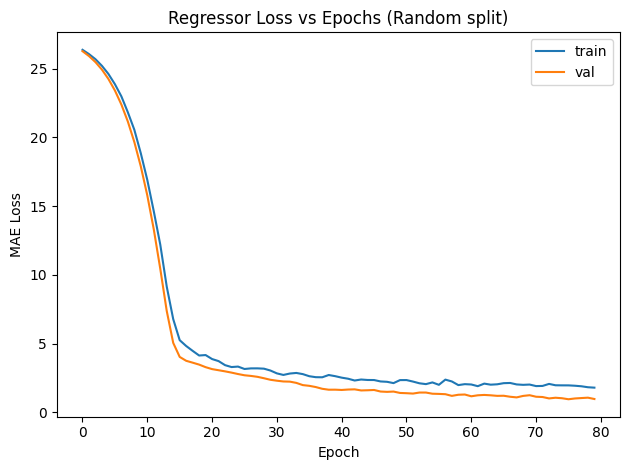

In [19]:
plt.figure()
plt.plot(hist_reg.history["loss"], label="train")
plt.plot(hist_reg.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Regressor Loss vs Epochs (Random split)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "reg_loss_vs_epochs_random.png", dpi=200)
plt.show()

## 7. Task B — Evaluation

Pearson r: 0.5184
MAE: 0.9305


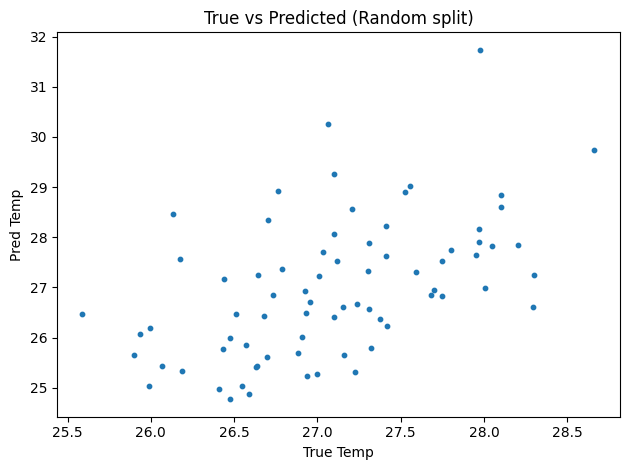

In [20]:
from scipy.stats import pearsonr

y_pred_r = reg.predict(X_test_rs, verbose=0).reshape(-1)

r, _ = pearsonr(y_test_r, y_pred_r)
mae = np.mean(np.abs(y_test_r - y_pred_r))

print("Pearson r:", round(r, 4))
print("MAE:", round(mae, 4))

plt.figure()
plt.scatter(y_test_r, y_pred_r, s=10)
plt.xlabel("True Temp")
plt.ylabel("Pred Temp")
plt.title("True vs Predicted (Random split)")
plt.tight_layout()
plt.savefig(FIG_DIR / "reg_true_vs_pred_random.png", dpi=200)
plt.show()

## 8. Regression with year-wise split (generalisation test)

In [21]:
years = sorted(df["Year"].unique())
rng = np.random.default_rng(RANDOM_SEED)
rng.shuffle(years)

n = len(years)
n_train = int(round(n * 0.70))
n_val = int(round(n * 0.15))

train_years = set(years[:n_train])
val_years = set(years[n_train:n_train+n_val])
test_years = set(years[n_train+n_val:])

ytrain_df = df[df["Year"].isin(train_years)].reset_index(drop=True)
yval_df = df[df["Year"].isin(val_years)].reset_index(drop=True)
ytest_df = df[df["Year"].isin(test_years)].reset_index(drop=True)

(len(ytrain_df), len(yval_df), len(ytest_df), n)

(348, 72, 72, 41)

In [22]:
X_ytrain, y_ytrain = Xy_for_regression(ytrain_df)
X_yval, y_yval = Xy_for_regression(yval_df)
X_ytest, y_ytest = Xy_for_regression(ytest_df)

y_feat_scaler = StandardScaler().fit(X_ytrain)
X_ytrain_s = y_feat_scaler.transform(X_ytrain)
X_yval_s = y_feat_scaler.transform(X_yval)
X_ytest_s = y_feat_scaler.transform(X_ytest)

target_scaler = StandardScaler()
y_ytrain_s = target_scaler.fit_transform(y_ytrain.reshape(-1,1)).reshape(-1)
y_yval_s = target_scaler.transform(y_yval.reshape(-1,1)).reshape(-1)

In [23]:
yreg = keras.Sequential([
    layers.Input(shape=(X_ytrain_s.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

yreg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="mae"
)

hist_yreg = yreg.fit(
    X_ytrain_s, y_ytrain_s,
    validation_data=(X_yval_s, y_yval_s),
    epochs=EPOCHS_REG,
    batch_size=BATCH_SIZE,
    verbose=0
)

# Save artifacts
yreg.save(MODEL_DIR / "yearwise_regression_model.keras")
joblib.dump(y_feat_scaler, MODEL_DIR / "yearwise_regression_feature_scaler.joblib")
joblib.dump(target_scaler, MODEL_DIR / "yearwise_regression_target_scaler.joblib")

['..\\models\\yearwise_regression_target_scaler.joblib']

Pearson r (year-wise): 0.8228
MAE (year-wise): 0.3157


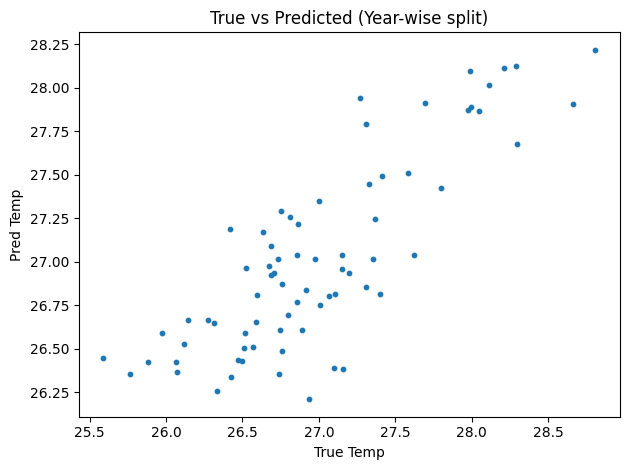

In [24]:
y_pred_scaled = yreg.predict(X_ytest_s, verbose=0).reshape(-1)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).reshape(-1)

r2, _ = pearsonr(y_ytest, y_pred)
mae2 = np.mean(np.abs(y_ytest - y_pred))

print("Pearson r (year-wise):", round(r2, 4))
print("MAE (year-wise):", round(mae2, 4))

plt.figure()
plt.scatter(y_ytest, y_pred, s=10)
plt.xlabel("True Temp")
plt.ylabel("Pred Temp")
plt.title("True vs Predicted (Year-wise split)")
plt.tight_layout()
plt.savefig(FIG_DIR / "reg_true_vs_pred_yearwise.png", dpi=200)
plt.show()

## 9. Final notes & next improvements

**What’s strong**
- Leakage-safe scaling (fit on train only)
- Clear separation of tasks + evaluations
- Year-wise split tests generalisation across time
- Saved models + scalers for reproducibility

**Next improvements**
- Hyperparameter search (width/depth, LR, dropout, early stopping)
- Add calibration / ROC-AUC for classification
- Add residual analysis for regression
- Report parameter counts and compare against data size